In [1]:
!pip install rasterio pandas openpyxl geopandas matplotlib
!pip install gdown
!pip install Pillow
!pip install tqdm


In [2]:
import rasterio
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import rasterio
from rasterio.plot import show
from rasterio.enums import Resampling
from rasterio.warp import transform


import json
import pprint
import gdown
import csv
import re


In [3]:
# importing dataset
file_id = "1QMUGMu-kQNyHPttE9u9lM_WGCnA6xtBS"
url = f"https://drive.google.com/uc?id={file_id}"


output = "flood.tif"
gdown.download(url, output, quiet=False)


Downloading...
From (original): https://drive.google.com/uc?id=1QMUGMu-kQNyHPttE9u9lM_WGCnA6xtBS
From (redirected): https://drive.google.com/uc?id=1QMUGMu-kQNyHPttE9u9lM_WGCnA6xtBS&confirm=t&uuid=568e0d93-6451-4b86-8556-0fd608ff4102
To: /content/flood.tif
100%|██████████| 4.24G/4.24G [00:43<00:00, 98.5MB/s]


'flood.tif'

taking info from google map

In [4]:
#importing google map data

file_id = "1AG2r7Jlj1sqt9jg0fro8bEMTDUyE6O9u"
url = f"https://drive.google.com/uc?id={file_id}"


output = "locations.json"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1AG2r7Jlj1sqt9jg0fro8bEMTDUyE6O9u
To: /content/locations.json
100%|██████████| 23.5k/23.5k [00:00<00:00, 15.0MB/s]


'locations.json'

In [5]:
# Load the JSON file
def load_json_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data

def count_locations(data):
    location_count = 0

    if isinstance(data, dict):
        for key, value in data.items():

            if isinstance(value, list):
                location_count += len(value)
            elif isinstance(value, dict):
                location_count += count_locations(value)
    elif isinstance(data, list):
        location_count += len(data)

    return location_count


file_path = '/content/locations.json'

json_data = load_json_file(file_path)

location_count = count_locations(json_data)

# Print the number of locations
print(f"Number of locations in the file: {location_count}")


Number of locations in the file: 61


In [6]:

# extract latitude and longitude from the google_maps_url
def extract_coordinates_from_url(url):
    # extract latitude and longitude from the URL
    match = re.search(r'(-?\d+\.\d+),(-?\d+\.\d+)', url)
    if match:
        latitude = float(match.group(1))
        longitude = float(match.group(2))
        return latitude, longitude
    return None, None

# extract transformer locations
def extract_transformer_locations(data):
    transformers = []

    # Counter for sequential naming of transformers
    counter = 1

    for feature in data.get("features", []):
        properties = feature.get("properties", {})
        google_maps_url = properties.get("google_maps_url")

        if google_maps_url:
            latitude, longitude = extract_coordinates_from_url(google_maps_url)
            if latitude and longitude:

                transformer_name = f"tran{counter}"
                transformers.append({
                    'name': transformer_name,
                    'latitude': latitude,
                    'longitude': longitude
                })
                counter += 1

    return transformers

# Load the JSON file
file_path = '/content/locations.json'
with open(file_path, 'r', encoding='utf-8') as f:
    data = json.load(f)

# Extract the transformer locations
transformer_locations = extract_transformer_locations(data)

# Check if any transformers were found
if not transformer_locations:
    print("No valid transformer locations found.")
else:
    # Save to CSV
    output_file = '/content/transformers_coordinates.csv'
    with open(output_file, mode='w', newline='', encoding='utf-8') as file:
        writer = csv.DictWriter(file, fieldnames=['name', 'latitude', 'longitude'])
        writer.writeheader()
        for transformer in transformer_locations:
            writer.writerow(transformer)

    print(f"Transformer locations have been saved to {output_file}.")


Transformer locations have been saved to /content/transformers_coordinates.csv.


In [7]:
tif_path = '/content/flood.tif'
# Path to the TIF file and CSV file
csv_path = '/content/transformers_coordinates.csv'

# Open the CSV file containing transformer coordinates
transformer_data = pd.read_csv(csv_path)

# Open the TIF file
with rasterio.open(tif_path) as dataset:
    dataset_crs = dataset.crs
    print(f"Dataset CRS: {dataset_crs}")

    index_values = []

    for index, row in transformer_data.iterrows():
        lon = row['longitude']
        lat = row['latitude']

        transformer_x, transformer_y = transform('EPSG:4326', dataset_crs.to_string(), [lon], [lat])

        row_index, col_index = dataset.index(transformer_x[0], transformer_y[0])

        window = dataset.read(1, window=rasterio.windows.Window(col_index - 1, row_index - 1, 3, 3))

        if window.shape[0] > 0 and window.shape[1] > 0:
            index_value = window[1, 1]
            index_values.append(index_value)
        else:
            index_values.append(None)

transformer_data['Flood Susceptibility Index'] = index_values

output_csv_path = '/content/transformers_with_index.csv'
transformer_data.to_csv(output_csv_path, index=False)

print(f"New CSV file with Flood Susceptibility Index has been created at: {output_csv_path}")


Dataset CRS: EPSG:3979
New CSV file with Flood Susceptibility Index has been created at: /content/transformers_with_index.csv


In [8]:
import rasterio
from rasterio.warp import transform
from rasterio.windows import Window
from rasterio.enums import Resampling
import numpy as np

#  the latitude and longitude boundaries for Sandy Hill, Ottawa
min_lat, max_lat = 45.4195, 45.4332
min_lon, max_lon = -75.6868, -75.6635

tif_path = '/content/flood.tif'
output_path = '/content/sandy_hill_flood.tif'

with rasterio.open(tif_path) as dataset:
    dataset_crs = dataset.crs

    lon_lat_bounds = [[min_lon, max_lon], [min_lat, max_lat]]
    transformed_bounds = transform('EPSG:4326', dataset_crs, lon_lat_bounds[0], lon_lat_bounds[1])

    min_row, min_col = dataset.index(transformed_bounds[0][0], transformed_bounds[1][1])  # Upper left corner
    max_row, max_col = dataset.index(transformed_bounds[0][1], transformed_bounds[1][0])  # Lower right corner

    # Create a window around Sandy Hill
    window = Window.from_slices((min_row, max_row), (min_col, max_col))

    # Read the data within this window
    data = dataset.read(1, window=window)

    # Prepare metadata for the output TIFF
    out_meta = dataset.meta.copy()
    out_meta.update({
        "driver": "GTiff",
        "height": window.height,
        "width": window.width,
        "transform": rasterio.windows.transform(window, dataset.transform)
    })

    # Export the cropped data to a new TIFF file
    with rasterio.open(output_path, "w", **out_meta) as dest:
        dest.write(data, 1)

print(f"Exported Sandy Hill flood susceptibility data to {output_path}")


Exported Sandy Hill flood susceptibility data to /content/sandy_hill_flood.tif


In [9]:
# importing font
file_id = "1mliEg2ZcWfTRD-1LdzVy7_r3Ep66Lpet"
url = f"https://drive.google.com/uc?id={file_id}"


output = "Times New Roman.ttf"
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1mliEg2ZcWfTRD-1LdzVy7_r3Ep66Lpet
To: /content/Times New Roman.ttf
100%|██████████| 834k/834k [00:00<00:00, 110MB/s]


'Times New Roman.ttf'

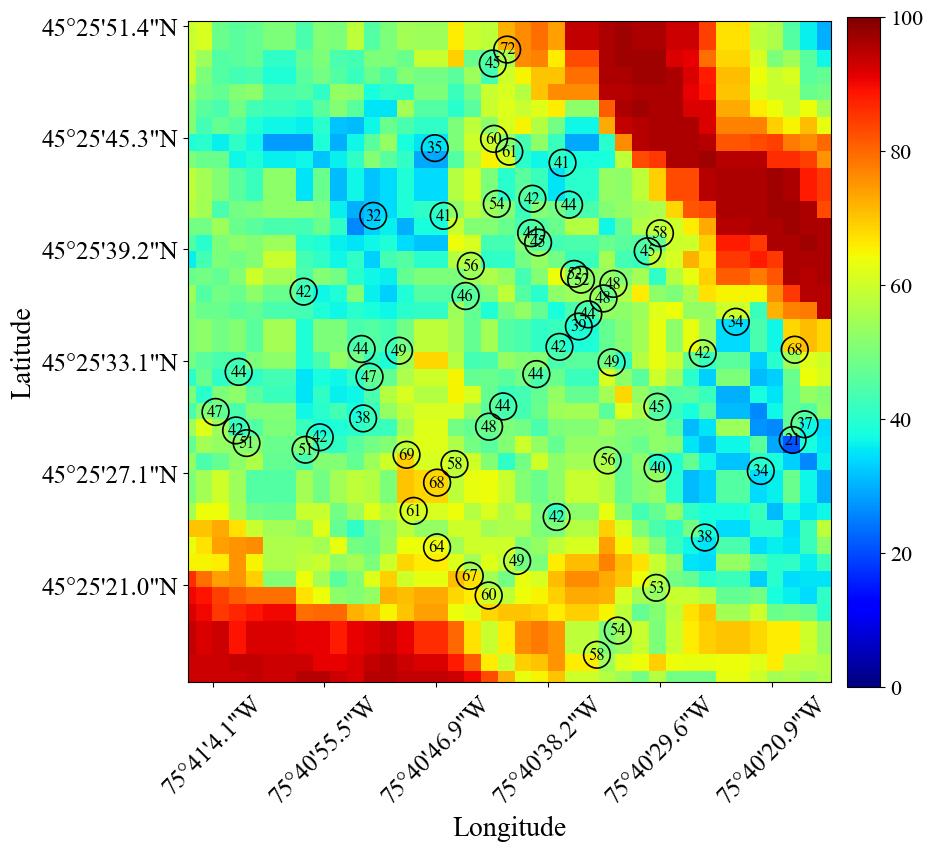

In [10]:
import rasterio
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties, fontManager
from matplotlib.ticker import FuncFormatter
from rasterio.plot import show
import pandas as pd
from pyproj import Transformer

font_path = "/content/Times New Roman.ttf"
font_prop = FontProperties(fname=font_path)
fontManager.addfont(font_path)
plt.rcParams['font.family'] = font_prop.get_name()

# Load the transformer data with latitude and longitude information
transformer_data_path = '/content/transformers_with_index.csv'
transformer_data = pd.read_csv(transformer_data_path)

# Load and display the map with annotations for Sandy Hill
sandy_hill_tif_path = '/content/sandy_hill_flood.tif'

with rasterio.open(sandy_hill_tif_path) as dataset:
    transformer = Transformer.from_crs("EPSG:4326", dataset.crs, always_xy=True)

    transformer_data['x'], transformer_data['y'] = transformer.transform(
        transformer_data['longitude'].values, transformer_data['latitude'].values
    )

    margin = 50
    min_x, max_x = transformer_data['x'].min() - margin, transformer_data['x'].max() + margin
    min_y, max_y = transformer_data['y'].min() - margin, transformer_data['y'].max() + margin

    # Create a square figure
    fig, ax = plt.subplots(figsize=(10, 10))  # Square figure, slightly larger

    # Show the flood susceptibility map with 'jet' colormap
    img = show(dataset, ax=ax, cmap='jet')
    img.get_images()[0].set_clim(0, 100)

    cbar = fig.colorbar(img.get_images()[0], ax=ax, orientation='vertical', pad=0.02, shrink=0.87)
    cbar.ax.tick_params(labelsize=16)

    ax.set_aspect('equal', adjustable='box')
    ax.set_xlim(min_x, max_x)
    ax.set_ylim(min_y, max_y)

    inverse_transformer = Transformer.from_crs(dataset.crs, "EPSG:4326", always_xy=True)

    def decimal_to_dms(deg, is_latitude):
        d = int(abs(deg))
        m = int((abs(deg) - d) * 60)
        s = round((abs(deg) - d - m / 60) * 3600, 1)
        direction = (
            'N' if is_latitude and deg >= 0 else
            'S' if is_latitude else
            'E' if not is_latitude and deg >= 0 else
            'W'
        )
        return f"{d}°{m}'{s}\"{direction}"

    # Function to transform axis values to DMS format
    def format_coord(value, axis):
        if axis == 'x':  # Longitude
            lon, _ = inverse_transformer.transform(value, min_y)
            return decimal_to_dms(lon, is_latitude=False)
        elif axis == 'y':  # Latitude
            _, lat = inverse_transformer.transform(min_x, value)
            return decimal_to_dms(lat, is_latitude=True)

    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: format_coord(x, 'x')))
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: format_coord(y, 'y')))

    offset_step = 3
    for i, row in transformer_data.iterrows():
        offset_x = (i % 2) * offset_step - offset_step // 2
        offset_y = (i % 3) * offset_step - offset_step // 2

        ax.text(row['x'] + offset_x, row['y'] + offset_y, f"{row['Flood Susceptibility Index']}",
                color="black", fontsize=12, ha='center', va='center', fontweight='bold',
                bbox=dict(boxstyle="circle,pad=0.3", facecolor='none', edgecolor='black', linewidth=1.2))

    ax.set_xlabel("Longitude", fontsize=20)
    ax.set_ylabel("Latitude", fontsize=20)
    ax.tick_params(axis='both', which='major', labelsize=18)

    ax.tick_params(axis='x', labelrotation=45)
    fig.savefig("sandy_hill_flood_map.pdf", format="pdf", bbox_inches="tight")

    plt.show()
